<a href="https://colab.research.google.com/github/TransRadOnc-HIT/multi-omics-SSMP2023/blob/main/Hands_on_1_DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Omics Data Pre-Processing**

---

In this notebook, we'll explore essential preprocessing steps for data integration. The chosen preprocessing techniques often depend on the specific problem, technology used,
and the number of available samples. Different omics layers might require distinct preprocessing workflows. Here, we present a  pipeline that can be tailored to specific requirements.

We'll cover the following:
- **Dataset overview**: A brief glimpse of our data.
- **Removing redundant or non-essential features**: Sifting through to retain pertinent data.
- **Handling missing values**: Strategies to pinpoint and manage missing data .
- **Eliminating highly correlated features**: Pruning data that's overly repetitive or analogous.
- **Data standardization**


---




---


The dataset for this notebook consists of data from 298 H&N cancer patients across four different institutions.

- **Data Reference**: [The Cancer Imaging Archive - Head-Neck-PET-CT](https://wiki.cancerimagingarchive.net/display/Public/Head-Neck-PET-CT)


**Omics Examined**: FDG-PET/CT, RT CT, and RTDOSE


### **Setup**

We'll install the lifelines package, essential for the survival analysis tasks we'll be tackling later in this notebook.

In [ ]:
!pip install lifelines

In the next cell, we're importing necessary libraries for our analysis: **numpy** and **pandas** for data manipulation, **matplotlib** and **seaborn** for data visualization, **sklearn** for machine learning tools and preprocessing, and **os** for handling file paths.

In [ ]:
import numpy as np #Fundamental package for scientific computing
import pandas as pd #For data manipulation and analysis
import matplotlib.pyplot as plt #2D plotting library
import seaborn as sns #Python data visualization library based on matplotlib
import warnings #Typically issued in situations where it is useful to alert the user of some condition in a program
from collections import Counter #Supports iterations
from os import path
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler # Feature scaling

import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
warnings.filterwarnings('ignore') #Ignores all warnings

data_path = "https://raw.githubusercontent.com/TransRadOnc-HIT/multi-omics-SSMP2023/main/data/hands-on1/"

### **Data loading and intial structuring**



In this section, we import the survival and omics datasets, refining the data for consistency in identifiers and structuring.

In [ ]:
print("RAW MULTIOMICS DATASET")

survival = pd.read_csv(data_path + "survival.csv",sep=',') #Reading survival data
survival = survival.set_index('PatientID')

# Drop any rows with NaN values
survival.dropna(inplace=True)

dataframe0 = pd.read_csv(data_path + "clinical.csv",sep=',',dtype={'inst': object}) #Reading clinical dataset
dataframe0 = dataframe0.set_index('PatientID')
dataframe0["Sex"] = dataframe0["Sex"].str.upper()
dataframe0.index.name = None
print("CLINICAL DATA :", dataframe0.shape)

dataframe1 = pd.read_csv(data_path + "radiomics_CT.csv",sep=',') #Reading CT dataset
dataframe1 = dataframe1.set_index('PatientID')
dataframe1.index.name = None
print("CT :", dataframe1.shape)

dataframe2 = pd.read_csv(data_path + "radiomics_DD.csv",sep=',') #Reading DD dataset
dataframe2 = dataframe2.set_index('PatientID')
dataframe2.index.name = None
print("DD :", dataframe2.shape)

dataframe3 = pd.read_csv(data_path + "radiomics_PT.csv",sep=',') #Reading PET dataset
dataframe3 = dataframe3.set_index('PatientID')
dataframe3.index.name = None
print("PET :", dataframe3.shape)



RAW MULTIOMICS DATASET
CLINICAL DATA : (298, 15)
CT : (274, 1218)
DD : (175, 1476)
PET : (271, 1476)


#### **Clinical feature preprocessing**
Before diving into our preprocessing steps, we'll first refine the clinical features. We establish a 30% threshold for permissible missing data within each column. By computing the missing data percentages for every feature and subsequently filtering out those surpassing our threshold, we ensure that our remaining features have a maximum of 30% missing values. This approach not only elevates data quality but also minimizes potential biases as we move forward.

In [ ]:
threshold = 20  # Set missing data threshold in %

# Calculate the percentage of missing data for each column
missing_percentage = dataframe0.isna().mean().round(4) * 100

# Columns to keep based on the shold
cols_to_keep = missing_percentage[missing_percentage <= threshold].index.tolist()

# Filter dataframe based on these columns
dataframe0 = dataframe0[cols_to_keep]


In our next step, we'll be binning continuous data into distinct categories. This technique aids in simplifying our analysis, making visualizations clearer, and facilitates certain statistical tests. However, keep in mind that while binning provides this clarity, it can result in a loss of granular information. Additionally, our chosen bin boundaries can introduce biases. As we proceed, always consider the trade-offs between the ease of interpretation and the potential loss or distortion of data.

In [ ]:
def bin_feature(dataframe, feature, na_placeholder=np.nan, na_value='NA'):
    """
    Bins a continuous feature into specified intervals.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the feature to be binned.
    - feature (str): Name of the feature to bin.
    - na_placeholder (int, float or None, optional): Placeholder value for NA values. Defaults to np.nan.
    - na_value (str or int, optional): The representation of NA in the data. Defaults to 'NA'.

    Returns:
    - pd.DataFrame: DataFrame with the binned feature.
    """

    # Intervals for binning
    bins = [0, 40, 70, 100]
    labels = ['Low', 'Medium', 'High']

    # Handle NA values
    dataframe[feature] = dataframe[feature].replace(na_value, na_placeholder)

    # Create a new binned column
    dataframe[f'{feature}'] = pd.cut(dataframe[feature].astype(float), bins=bins, labels=labels, right=True, include_lowest=True)

    return dataframe
dataframe0 =  bin_feature(dataframe0, "PET_time")
dataframe0 =  bin_feature(dataframe0, "RT_time")
dataframe0 =  bin_feature(dataframe0, "RT_endtime")

# Defining the bins for age categorization
bins = [0, 39, 65, float('inf')]
labels = ['<40y', '40-65y', '>65y']

# Bin the age feature
dataframe0['Age'] = pd.cut(dataframe0['Age'], bins=bins, labels=labels, right=True, include_lowest=True)




Fianlly we perform one-hot encoding on the clinical features, converting categorical variables into a format that can be provided to machine learning algorithms. By setting drop_first=True, we avoid multicollinearity issues. After encoding, the dataframe is then transposed, flipping its rows and columns to match the other omics dataframes.

In [ ]:
#one hot encodin
dataframe0 = pd.get_dummies(dataframe0, drop_first=True)
dataframe0


#### **Adjusting dataframes**
In this code segment, we consolidate our datasets into a dictionary, `dataframes`, where each dataset is named by its type: CLI for clinical data, CT for CT radiomics, DD for dose distrubtion, PET for PET radiomics.



In [ ]:
dataframes = {
    "CLI":dataframe0,
    "CT": dataframe1,
    "DD": dataframe2,
    "PET": dataframe3
}


To make future plotting and visualization tasks more straightforward, we then prefix the row indices of each dataframe with its respective omics or modality name. This way, each row identifier will clearly indicate the dataset source, simplifying any subsequent comparative analyses or visual representations. The shape of each dataframe is printed, providing a quick overview of the number of samples and features within each dataset.

In [ ]:
# Iterate through dataframes and prepend omics name to column names for easier visualization
for omics_name, df in dataframes.items():
    # Check if the first column already starts with the omics_name
    if not df.columns[0].startswith(f"{omics_name}_"):
        new_columns = [f"{omics_name}_{col}" for col in df.columns]
        df.columns = new_columns
    print(f"{omics_name}: {df.shape}")

### **Data overview: omics layers & survival outcomes**

Next we iterate through each dataframe and print a snapshot of its content, a concise summary, and basic descriptive statistics to offer an initial understanding of its structure and characteristics.

In [ ]:
for omics_name, df in dataframes.items():
    print(f"############### {omics_name} ###############")
    print(df.head())
    print(df.info())
    print(df.describe())

#### **Outcome exploration**
Time-to-event data, also known as survival data, deals with the time until the occurrence of an event of interest (e.g., death, failure, recurrence, etc.). One of the most common graphical representations of time-to-event data is the Kaplan-Meier survival curve.

To visualize time-to-event data in Python, the lifelines library is commonly used. Here's how to do it:

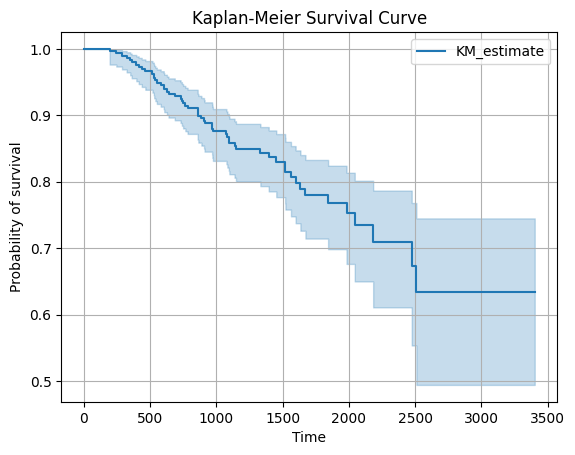

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(survival["Survival"], survival["Death"])

kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time")
plt.ylabel("Probability of survival")
plt.grid(True)
plt.show()

The following functions aid in visualizing Kaplan-Meier survival curves for individual one-hot encoded features, as well as for lists of features. These visualizations help analyze the impact of clinical features on survival outcomes. We can first take a look at the clinical features:

In [ ]:
column_dict = {col: i for i, col in enumerate(dataframes["CLI"].columns)}
column_dict

and then we can plot for the feature of interest by specifying its index e.g. for example, to look at Age_40-65y we choose index 4. We can see that patients from between 40 and 65 years old have a higher survival probility.

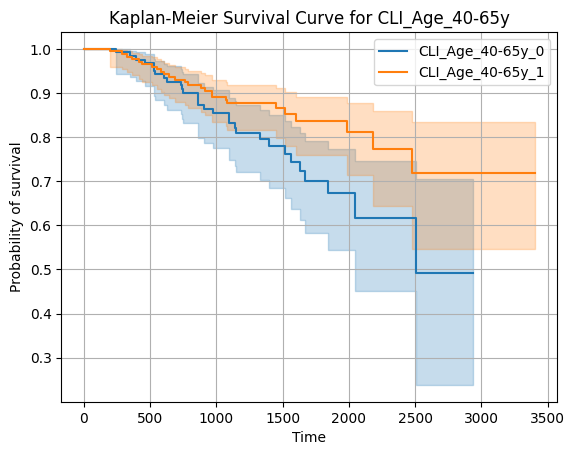

In [ ]:
def plot_km_curve_for_feature(survival_df, dataframe, feature_identifier):
    """
    Plot the Kaplan-Meier survival curves for the specified one-hot encoded feature.

    Parameters:
    - survival_df: The survival data DataFrame.
    - dataframe: The DataFrame with one-hot encoded features.
    - feature_identifier: Either the name or the index of the one-hot encoded feature to plot.

    Returns: None
    """
    kmf = KaplanMeierFitter()

    # Check if the identifier is an integer (indicating an index). If so, get the feature name by index.
    if isinstance(feature_identifier, int):
        feature_name = dataframe.columns[feature_identifier]
    else:
        feature_name = feature_identifier

    # Find common patients between the two dataframes
    common_patients = survival_df.index.intersection(dataframe.index)

    # Group 0
    idx_0 = dataframe.loc[common_patients,feature_name] == 0
    patient_ids_0 = common_patients[idx_0]
    kmf.fit(survival_df.loc[patient_ids_0, "Survival"], survival_df.loc[patient_ids_0, "Death"], label=f'{feature_name}_0')
    kmf.plot()

    # Group 1
    idx_1 = dataframe.loc[ common_patients,feature_name] == 1
    patient_ids_1 = common_patients[idx_1]
    kmf.fit(survival_df.loc[patient_ids_1, "Survival"], survival_df.loc[patient_ids_1, "Death"], label=f'{feature_name}_1')
    kmf.plot()

    plt.title(f"Kaplan-Meier Survival Curve for {feature_name}")
    plt.xlabel("Time")
    plt.ylabel("Probability of survival")
    plt.grid(True)
    plt.show()

# Usage example:
plot_km_curve_for_feature(survival, dataframes["CLI"], 4)

Next we can plot features against each other, e.g., we can look at the different between institutions 2, 3 and 4.

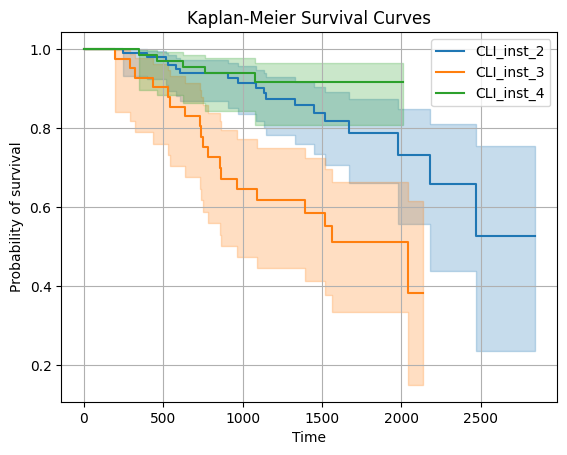

In [ ]:
def plot_km_curve_for_features(survival_df, dataframe, features, value=1):
    """
    Plot the Kaplan-Meier survival curves for a list of specified features based on a given value (0 or 1).

    Parameters:
    - survival_df: The survival data DataFrame.
    - dataframe: The DataFrame with one-hot encoded features.
    - features: List of features to plot.
    - value: The value (0 or 1) to filter the data on for all features. Default is 1.

    Returns: None
    """
    kmf = KaplanMeierFitter()

    # Find common patients between the two dataframes
    common_patients = survival_df.index.intersection(dataframe.index)

    for feature in features:
        # Check if the feature is given as an integer (indicating index). If so, get the feature name by index.
        if isinstance(feature, int):
            feature = dataframe.columns[feature]

        idx = dataframe.loc[common_patients,feature] == value
        patient_ids = common_patients[idx]
        kmf.fit(survival_df.loc[patient_ids, "Survival"], survival_df.loc[patient_ids, "Death"], label=feature)
        kmf.plot()

    plt.title(f"Kaplan-Meier Survival Curves")
    plt.xlabel("Time")
    plt.ylabel("Probability of survival")
    plt.grid(True)
    plt.legend()
    plt.show()

# Usage example:
features_to_plot = [0, 1, 2]
plot_km_curve_for_features(survival, dataframes["CLI"], features_to_plot)

### **Removal of redundant or non-essential features**

Next, we will tackle the challenge of handling duplicated data in our dataset. Duplicate features or samples, such as multiple probes for the same gene in gene expression data or radiomics features extracted from similar rois, can introduce noise and affect the accuracy of our analyses. Therefore, our next step is to systematically identify and remove these redundancies to ensure the reliability of our data.

In [ ]:
def remove_duplicated_data(dataframes_dict, print_output=True):
  """
  Processes a dictionary of DataFrames to remove both duplicated rows and columns from each DataFrame.
  It also provides an option to print the original and deduplicated shapes of the DataFrames.

  Parameters:
    dataframes_dict (dict): A dictionary where keys are strings representing the names (or types)
                            of DataFrames, and values are the corresponding pandas DataFrames.

    print_output (bool, optional): If set to True (default), the function will print the original
                                   and deduplicated shapes of each DataFrame. If set to False, no output will be printed.

  Returns:
    tuple: A tuple containing two dictionaries:
    dataframes_dict (dict): The input dictionary with each DataFrame having duplicated rows and columns removed.
    dropped_data (dict): A dictionary where keys are the same as the input dictionary, and values are another dictionary containing:
                        "dropped_rows": A DataFrame of rows that were detected as duplicates and removed.
                        "dropped_columns": A list of column names that were detected as duplicates and removed.
  """
  dropped_data = {}  # Dictionary to store the dropped rows and columns for each dataframe

  for omic, df in dataframes_dict.items():
      original_shape = df.shape

      # Reset index temporarily to check for duplicates
      temp_df = df.reset_index()

      # Track and remove duplicated rows
      duplicated_rows = temp_df[temp_df.duplicated()]
      deduplicated_df = temp_df.drop_duplicates().set_index(df.index.name or 'index')

      # Track and remove duplicated columns
      duplicated_columns = df.columns[df.T.duplicated()].tolist()
      deduplicated_df = deduplicated_df.T.drop_duplicates().T

      # Store dropped rows and columns in the dropped_data dictionary
      dropped_data[omic] = {
          "dropped_rows": duplicated_rows.set_index(df.index.name or 'index'),
          "dropped_columns": duplicated_columns
      }

      dataframes_dict[omic] = deduplicated_df

      # Print shapes before and after removing duplicates on the same line
      if print_output:
          print(f"{omic.upper()}: Original shape {original_shape}, after removing duplicates {deduplicated_df.shape}")

  return dataframes_dict, dropped_data


# Call the function with your dataframes_transposed
dataframes,dropped_data = remove_duplicated_data(dataframes, print_output=True)


On the other hand, you may have uninformative features in your dataset. For instance, we may have invariant features (those whose variance σ2 is null), or those that are null throughout. The following plots represent the population density distribution of feature variance (left) and row sums (right).These uninformative features will add nothing to any sample vs sample or feature vs feature comparisons that we may be interested. We will remove them from our dataset as they contribute with no information to our downstream analyses.

In [ ]:
# Determine the number of omics DataFrames
num_omics = len(dataframes)

# Create subplots for all omics DataFrames
fig, axes = plt.subplots(num_omics, 2, figsize=(12, 5 * num_omics))

# Iterate through dataframes and create plots for each omics
for i, (omics_name, df) in enumerate(dataframes.items()):
    # Compute feature variability (variance) for columns
    feature_variability = df.var(axis=0, skipna=True)

    # Identify columns with all zeros
    null_feature_count = (df.sum(axis=0) == 0).sum()

    # Create KDE plots for feature variability in the i-th subplot
    sns.kdeplot(feature_variability, ax=axes[i, 0])
    axes[i, 0].set_title(f'{omics_name} - Feature Variability')
    axes[i, 0].set_xlabel('Variance')

    # Plot a bar for the count of null features
    axes[i, 1].bar(1, null_feature_count)  # Only one bar showing count of all-zero columns
    axes[i, 1].set_title(f'{omics_name} - Null Features')
    axes[i, 1].set_ylabel('Count of All-Zero Columns')
    axes[i, 1].set_xticks([])  # Remove x-ticks as they are not relevant here

# Adjust layout and show all plots
plt.tight_layout()
plt.show()


Next we implement a feature filtering step to remove features with low variance (below a specified threshold) However, the specific threshold for what constitutes "low variance" can depend on the nature of your data and your analysis goals. You may want to adjust the threshold based on your domain knowledge and the specific characteristics of your dataset.

In [ ]:
def filter_low_variance_features(dataframes_dict, thresholds=0.001, default_threshold=0.01, print_output=True):
  """
  Processes a dictionary of DataFrames to remove features (columns) that have a variance below a specified threshold.
  The function is useful for feature selection, especially in contexts where features with low variance might not contribute significantly to a model.

  Parameters:
    - dataframes_dict (dict): A dictionary where keys are strings representing the names
    (or types) of DataFrames, and values are the corresponding pandas DataFrames.
    - thresholds (float, int, or dict, optional): The variance threshold below which features will be removed. It can be:
                  A single float or int value applied to all DataFrames.
                  A dictionary with keys corresponding to the keys in dataframes_dict and values being the thresholds for each DataFrame. Default is 0.001.
    - default_threshold (float, optional): The default variance threshold to use for any DataFrame not specified in the thresholds dictionary. Default is 0.01.
    - print_output (bool, optional): If set to True (default), the function will print the shape of each DataFrame after filtering and
                                     the names of the dropped features. If set to False, no output will be printed.

  Returns:
    - tuple: A tuple containing two items:
          filtered_dataframes_dict (dict): The input dictionary with low variance features removed from each DataFrame.
          dropped_features (dict): A dictionary where keys are the same as the input dictionary, and values are lists of feature names
                                  that were dropped due to low variance.
  """
  dropped_features = {}

  # Make a copy of the dataframes_dict to avoid modifying the original
  filtered_dataframes_dict = dataframes_dict.copy()

  if isinstance(thresholds, (float, int)):
      thresholds = {omic: thresholds for omic in dataframes_dict.keys()}

  for omic, df in filtered_dataframes_dict.items():
      threshold = thresholds.get(omic, default_threshold)

      selector = VarianceThreshold(threshold=threshold)
      selected_data = selector.fit_transform(df)
      dropped_indices = ~selector.get_support()
      dropped_feature_names = df.columns[dropped_indices]
      dropped_features[omic] = dropped_feature_names

      df_selected = pd.DataFrame(selected_data, index=df.index, columns=df.columns[selector.get_support()])
      filtered_dataframes_dict[omic] = df_selected

      num_dropped = len(dropped_feature_names)

      if print_output:
          print(f"{omic} after removing low variance features: {df_selected.shape}")
          print(f"Number of features dropped in {omic}: {num_dropped}")
          if num_dropped > 0:
              print(f"Features dropped in {omic}: {', '.join(dropped_feature_names)}\n")

  return filtered_dataframes_dict, dropped_features

# Example usage with different thresholds for each omic type and a default threshold of 0.03
#thresholds = {'CLI': 0.01, 'T2': 0.0001,'T1': 0.0001,'T1Gd': 0.0001,'FLAIR': 0.0001}
#default_threshold = 0.01
dataframes, uninformative_features = filter_low_variance_features(dataframes,default_threshold=0.01, print_output=True)


### **Dealing with missing values and highly correlated features**

We will first display the missing values per omics layer

In [ ]:
# Calculate NA ratios per sample for each omics
na_ratios_per_sample = {omic: df.isna().sum() / df.shape[0] for omic, df in dataframes.items()}

# Create a plot for each omics
fig, axes = plt.subplots(len(dataframes), figsize=(12, 3 * len(dataframes)))

for i, (omic, na_ratios) in enumerate(na_ratios_per_sample.items()):
    ax = axes[i]
    sns.barplot(
        x=np.arange(0, na_ratios.shape[0]),
        y=na_ratios.values,
        ax=ax
    )
    ax.set_xlabel('Sample')
    ax.set_ylabel('Ratio of NAs')
    ax.set_title(f'NA Ratios per Sample - {omic}')

plt.tight_layout()
plt.show()


How we handle these missing values often depends on the nature of the data and the type of analysis. Here we remove columns containing NaN values from the radiomics dataframes. Common strategies are dropping missing values, imputating missing values, leave-as-is, flagging with a new category. It is important to analyze the patterns of missingness in your data. For instance, are missing values concentrated in specific rows or columns? Is there a pattern or reason why data might be missing? \\
Here we are dropping the missing values:



In [ ]:
def drop_columns_with_nan(dataframes_dict, print_output=True):
  """
  Processes a dictionary of DataFrames to remove columns that contain any NaN values.
  This can be particularly useful in data preprocessing where features with missing values
  need to be excluded from analyses or models.

  Parameters:
  - dataframes_dict (dict): A dictionary where keys are strings representing the names (or types) of DataFrames,
                            and values are the corresponding pandas DataFrames.

  - print_output (bool, optional): If set to True (default), the function will print the shape of each DataFrame
                                  after columns with NaN values have been dropped, as well as the names of the removed columns. If set to False, no output will be printed.

  Returns:
  - new_dataframes_dict (dict): The input dictionary with columns containing NaN values removed from each DataFrame.
  """
  new_dataframes_dict = {}
  removed_features = {}
  for omic, df in dataframes_dict.items():
      # Identify columns with NaN values
      nan_columns = df.columns[df.isna().any()].tolist()

      # Drop columns with NaN values
      new_df = df.dropna(axis=1, how='any')

      # Store removed features
      removed_features[omic] = nan_columns

      new_dataframes_dict[omic] = new_df
      if print_output:
          print(f"{omic.upper()} shape after dropping columns with NaN values: {new_df.shape}")
          if nan_columns:
              print(f"Features removed in {omic}: {', '.join(nan_columns)}")
  return new_dataframes_dict

# Call the function with your dataframes_transposed
dataframes = drop_columns_with_nan(dataframes, print_output=True)

Next, we remove columns that are highly correlated based on a specified threshold to mitigate multicollinearity, which can compromise the interpretability and stability of some statistical models. By eliminating redundant features, we aim to enhance model performance and generalization.

In [ ]:
def remove_highly_correlated_features(dataframes_dict, threshold=0.90, print_output=True, plot_heatmap=False):
  """
  Processes a dictionary of DataFrames to remove features that are highly correlated with other features.
  High correlations among features can cause multicollinearity issues in certain models, so it can be beneficial to remove such features during data preprocessing.

  Parameters:
  - dataframes_dict (dict): A dictionary where keys are strings representing the names (or types) of DataFrames, and values are the corresponding pandas DataFrames.

  - threshold (float, optional): The correlation coefficient threshold above which features will be considered highly correlated and thus will be removed. Default is 0.90.

  - print_output (bool, optional): If set to True (default), the function will print the shape of each DataFrame after removal of highly correlated features,
                                   as well as the names of the removed columns. If set to False, no output will be printed.

  - plot_heatmap (bool, optional): If set to True, the function will plot a heatmap of the correlation matrix for each DataFrame. This can be useful for visual
                                   inspection of correlations among features. Default is False.

  Returns:
  - tuple: A tuple containing two items:
  - dataframes_dict (dict): The input dictionary with highly correlated features removed from each DataFrame.
  - dropped_features (dict): A dictionary where keys are the same as the input dictionary, and values are lists of feature names that were dropped due to high correlation.
  """
  dropped_features = {}

  for omic, df in dataframes_dict.items():

      # Calculate the correlation matrix
      corr_matrix = df.corr().abs()

      # Create a mask to identify highly correlated features
      upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
      to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

      # Plot the heatmap if required
      if plot_heatmap:
          plt.figure(figsize=(12, 10))
          sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
          plt.title(f"Heatmap of Correlation for {omic}")
          plt.show()

      # Drop the highly correlated features
      df_filtered = df.drop(columns=to_drop)

      # Store the list of removed features
      dropped_features[omic] = to_drop

      # Update the DataFrame in dataframes_dict
      dataframes_dict[omic] = df_filtered

      num_dropped = len(to_drop)

      if print_output:
          print(f"{omic} after removing highly correlated features: {df_filtered.shape}")
          print(f"Number of features dropped in {omic}: {num_dropped}")
          if num_dropped > 0:
              print(f"Features dropped in {omic}: {', '.join(to_drop)}\n")

  return dataframes_dict, dropped_features
dataframes, dropped_corr_features = remove_highly_correlated_features(dataframes, print_output=True,plot_heatmap=True,threshold=0.90)

In [ ]:
# 1. Find Common Patients
# Start with the patients in the survival dataframe
common_patients = set(survival.index)

# Find intersection with patients in each omics dataframe
for omic_name, df in dataframes.items():
    common_patients = common_patients.intersection(df.index)

print("Number of patients present in all dataframes and the survival dataframe:", len(common_patients))

# 2. Perform Stratified Sampling
# Filter the survival dataframe to only the common patients
filtered_survival_df = survival.loc[common_patients]

from sklearn.model_selection import StratifiedShuffleSplit

# Set the number of patients for the test set
n_test_patients = 40

splitter = StratifiedShuffleSplit(n_splits=1, test_size=n_test_patients, random_state=42)
train_index, test_index = next(splitter.split(filtered_survival_df, filtered_survival_df['Death']))

train_patients = filtered_survival_df.iloc[train_index].index
test_patients = filtered_survival_df.iloc[test_index].index

# 3. Split the Dataframes
dataframes_train = {}
dataframes_test = {}

for omic_name, df in dataframes.items():
    dataframes_train[omic_name] = df.loc[df.index.difference(test_patients)]  # All rows except the test patients
    dataframes_test[omic_name] = df.loc[test_patients]

# Displaying sizes
for omic_name, df_train in dataframes_train.items():
    print(f"{omic_name} Train: {df_train.shape}")
    print(f"{omic_name} Test: {dataframes_test[omic_name].shape}")

Number of patients present in all dataframes and the survival dataframe: 172
CLI Train: (258, 46)
CLI Test: (40, 46)
CT Train: (234, 331)
CT Test: (40, 331)
DD Train: (135, 312)
DD Test: (40, 312)
PET Train: (231, 204)
PET Test: (40, 204)


### **Data standardization**

Next, we apply the MinMaxScaler to normalize every DataFrame in the provided dictionary, ensuring that all numerical features lie between 0 and 1. This step is essential for many machine learning algorithms, as it guarantees consistent influence of each feature during training. However, DataFrames labeled "CLI" are deliberately excluded from this transformation to preserve their original state. Through this scaling process, we strive to boost model accuracy and predictive capability.

In [ ]:
for df,item in dataframes.items():
  print(item.shape)

(298, 46)
(274, 331)
(175, 312)
(271, 204)


In [ ]:
def scale_dataframes(dataframes_train_dict, dataframes_test_dict):
    """
    Scales all dataframes in the provided training dictionary using StandardScaler and
    applies the transformation learned from each training dataframe
    to the corresponding dataframe in the test dictionary.

    Parameters:
    - dataframes_train_dict (dict): Dictionary containing training dataframes to be scaled.
    - dataframes_test_dict (dict): Dictionary containing test dataframes where the scaling transformation learned from the training data is applied.

    Returns:
    - tuple: (Dictionary containing scaled training dataframes, Dictionary containing scaled test dataframes)
    """
    scaled_train_dict = {}
    scaled_test_dict = {}

    for key, train_df in dataframes_train_dict.items():
        if key != "CLI":
            scaler = StandardScaler()

            # Fit and transform the training data
            scaled_train_data = scaler.fit_transform(train_df)
            scaled_train_dict[key] = pd.DataFrame(scaled_train_data, columns=train_df.columns, index=train_df.index)


            if dataframes_test_dict:
              # Transform the test data based on the fitted scaler
              test_df = dataframes_test_dict.get(key, pd.DataFrame())  # get the test dataframe for the current key, if it doesn't exist, use an empty dataframe
              scaled_test_data = scaler.transform(test_df)
              scaled_test_dict[key] = pd.DataFrame(scaled_test_data, index=test_df.index, columns=test_df.columns)
        else:
            scaled_train_dict[key] = train_df
            if dataframes_test_dict:
              scaled_test_dict[key] = dataframes_test_dict[key]

    return scaled_train_dict, scaled_test_dict

Alternatively we can perform a Z-score normalization. This normalization method standardizes features by removing the mean and scaling to unit variance, thereby ensuring a consistent weight for each feature in subsequent analyses.  Opting for Z-score normalization offers an alternative approach to the MinMax scaling, catering to different modeling needs and data characteristics.

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_dataframes_zscore(dataframes_train_dict, dataframes_test_dict=None):
    """
    Applies Z-score normalization to all dataframes in the provided training dictionary and
    uses the scaler trained on each dataframe in the dictionary to scale
    the corresponding dataframe in the test dictionary.

    Parameters:
    - dataframes_train_dict (dict): Dictionary containing training dataframes to be normalized.
    - dataframes_test_dict (dict): Dictionary containing test dataframes where the scaling transformation learned from the training data is applied.

    Returns:
    - tuple: (Dictionary containing scaled training dataframes, Dictionary containing scaled test dataframes)
    """
    scaler = StandardScaler()
    scaled_train_dict = {}
    scaled_test_dict = {}

    for key, train_df in dataframes_train_dict.items():
        if key != "CLI":
            # Fit on the training data
            scaler.fit(train_df)

            # Transform training data
            scaled_train_data = scaler.transform(train_df)
            scaled_train_dict[key] = pd.DataFrame(scaled_train_data, columns=train_df.columns, index=train_df.index)

            # Check if the key exists in dataframes_test_dict
            if dataframes_test_dict:
              if key in dataframes_test_dict:
                  # Transform the test data using the fitted scaler
                  test_df = dataframes_test_dict[key]
                  scaled_test_data = scaler.transform(test_df)
                  scaled_test_dict[key] = pd.DataFrame(scaled_test_data, columns=test_df.columns, index=test_df.index)
              else:
                  print(f"Warning: Key '{key}' not found in test data dictionary.")
        else:
            scaled_train_dict[key] = train_df
            if dataframes_test_dict:
              if key in dataframes_test_dict:
                  scaled_test_dict[key] = dataframes_test_dict[key]
              else:
                  print(f"Warning: Key '{key}' not found in test data dictionary.")

    return scaled_train_dict, scaled_test_dict

dataframes, _ = scale_dataframes_zscore(dataframes)


Our final dataframes:

In [ ]:
for df,item in dataframes_train.items():
  print(item.shape)

(258, 46)
(234, 331)
(135, 312)
(231, 204)


# **Reflection and Further Improvements**

As we wrap up this notebook, it's essential to think on how to enhance our preprocessing steps. Effective preprocessing can significantly influence subsequent analysis and results.

### 1. Custom Preprocessing for Different Omics:
Each omics data layer might have distinct characteristics. By examining the shape and distribution of data for each omics type, we can design preprocessing steps tailored to each specific omics layer.
### 2. Resampling in Feature Reduction:
Instead of using the same data set for feature reduction, consider employing resampling methods. Techniques like bootstrapping can provide a more robust set of features.
### 3.Diverse Methods for Feature Reduction:
While we've utilized certain feature reduction techniques, exploring other methods or a combination of several can often yield better results.

### 4. Incorporating Known Biomarkers:
If there are well-known biomarkers relevant to your study, consider incorporating them into the feature reduction process. These can act as reference points and provide a biological context to the selected features.